# EDLIF model

[Jaras I, Harada T, Orchard ME, Maldonado PE, Vergara RC. Extending the integrate-and-fire model to account for metabolic dependencies. Eur J Neurosci. 2021 Aug;54(4):5249-5260. doi: 10.1111/ejn.15326. Epub 2021 Jul 16. PMID: 34109698.](https://onlinelibrary.wiley.com/doi/10.1111/ejn.15326)

[Free full article](https://www.researchgate.net/publication/352298690_Extending_the_integrate-and-fire_model_to_account_for_metabolic_dependencies)

### TODO:
- [] include equations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import os

from pynestml.frontend.pynestml_frontend import generate_nest_target

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")

<frozen importlib._bootstrap>:241: RuntimeWarning: compiletime version 3.8 of module 'pynestkernel' does not match runtime version 3.1
<frozen importlib._bootstrap>:241: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 880 from C header, got 888 from PyObject



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: master@61f08e0ea
 Built: Jul 14 2022 17:28:07

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
neuron_model = [
    "edlif_psc_base.nestml", # 0 
    "edlif_psc_nonlineardendrite.nestml", # 1
    "edlif_psc_supply_state.nestml", # 2
    "edlif_psc_supply_inline.nestml", # 3
    "edlif_psc_percent.nestml", # 4
    "edlif_psc_exp_percent.nestml", # 5
    "edlif_psc_alpha_percent.nestml" # 6
]
neuron_id = 5
generate_nest_target(input_path=neuron_model[neuron_id],
                     target_path="/tmp/nestml-component",
                     logging_level="INFO",
                     codegen_opts={"nest_path": NEST_SIMULATOR_INSTALL_LOCATION})

[1,GLOBAL, INFO]: List of files that will be processed:
[2,GLOBAL, INFO]: /home/wis/Documents/nestml/ehp/edlif/edlif_psc_exp_percent.nestml
[3,GLOBAL, INFO]: No module name specified; the generated module will be named "nestmlmodule"
[4,GLOBAL, INFO]: Start processing '/home/wis/Documents/nestml/ehp/edlif/edlif_psc_exp_percent.nestml'!
[6,edlif_psc_exp_percent, INFO, [50:31;50:39]]: Implicit magnitude conversion from pA to pA buffer with factor 1.0 
[7,edlif_psc_exp_percent, INFO, [50:13;50:22]]: Implicit magnitude conversion from mV / ms to pA / pF with factor 1.0 
[8,edlif_psc_exp_percent, INFO, [21:15;21:15]]: Implicit casting from (compatible) type 'integer' to 'real'.
[9,edlif_psc_exp_percent, INFO, [24:15;24:15]]: Implicit casting from (compatible) type 'integer' to 'real'.
[10,edlif_psc_exp_percent, INFO, [25:15;25:15]]: Implicit casting from (compatible) type 'integer' to 'real'.
[11,edlif_psc_exp_percent, INFO, [68:17;68:17]]: Implicit casting from (compatible) type 'integer' 

INFO:Analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "V_abs' = -V_abs / tau_m + ((I_kernel_ex__X__exc_spikes - I_kernel_in__X__inh_spikes) + I_e + I_stim) / C_m",
            "initial_values": {
                "V_abs": "0"
            }
        },
        {
            "expression": "ATP' = (((ATP_h - ATP) * K_ATP * homeostatic_s_enabled + ATP_basal) - ((ATP_basal + (E_ap_tr * E_ap / tau_ap / o_t) + ((ATP_kernel_ex__X__exc_spikes * E_syn_ex / tau_syn_atp_ex / w_max + ATP_kernel_in__X__inh_spikes * E_syn_in / tau_syn_atp_in / w_min) / o_t / 1.0)))) * o_t",
            "initial_values": {
                "ATP": "100"
            }
        },
        {
            "expression": "I_kernel_ex__X__exc_spikes = exp(-t / tau_syn_ex)",
            "initial_values": {}
        },
        {
            "expression": "ATP_kernel_ex__X__exc_spikes = exp(-t / tau_syn_atp_ex)",
            "initial_values": {}
        },
        {
            "expression": "I_kernel_in_

[47,edlif_psc_exp_percent, INFO, [24:15;24:15]]: Implicit casting from (compatible) type 'integer' to 'real'.
[48,edlif_psc_exp_percent, INFO, [25:15;25:15]]: Implicit casting from (compatible) type 'integer' to 'real'.
[49,edlif_psc_exp_percent, INFO, [68:17;68:17]]: Implicit casting from (compatible) type 'integer' to 'real'.
[50,edlif_psc_exp_percent, INFO, [73:17;73:17]]: Implicit casting from (compatible) type 'integer' to 'real'.
[51,edlif_psc_exp_percent, INFO, [74:16;74:16]]: Implicit casting from (compatible) type 'integer' to 'real'.
[52,edlif_psc_exp_percent, INFO, [75:16;75:16]]: Implicit casting from (compatible) type 'integer' to 'real'.
[53,edlif_psc_exp_percent, INFO, [76:16;76:16]]: Implicit casting from (compatible) type 'integer' to 'real'.
[54,edlif_psc_exp_percent, INFO, [77:20;77:20]]: Implicit casting from (compatible) type 'integer' to 'real'.
[55,edlif_psc_exp_percent, INFO, [78:20;78:20]]: Implicit casting from (compatible) type 'integer' to 'real'.
[56,edlif_

In [3]:
nest.Install("nestmlmodule")


Sep 02 18:11:26 Install [Info]: 
    loaded module nestmlmodule


Using neuron model: edlif_psc_exp_percent
idx: 0
idx: 1


/tmp/ipykernel_48615/786492069.py:105: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/tmp/ipykernel_48615/786492069.py:105: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


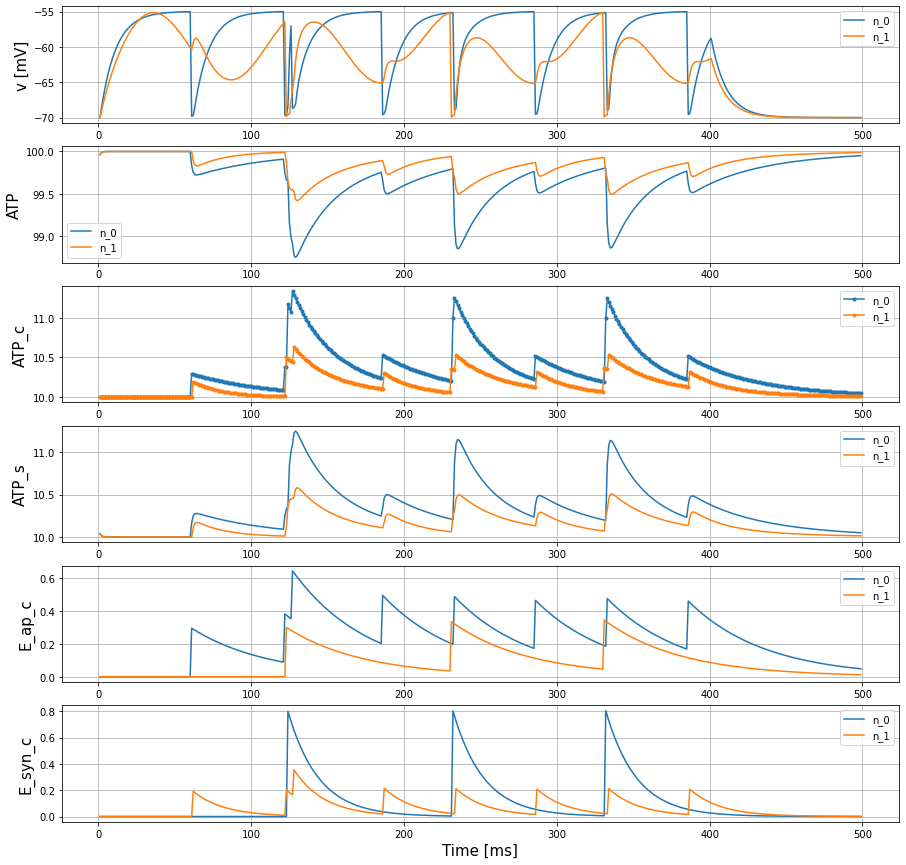

In [14]:
nest.set_verbosity("M_WARNING")
nest.ResetKernel()

neuron_model_name = neuron_model[neuron_id].split(".")[0]
print(f"Using neuron model: {neuron_model_name}")

#param dict
parameter_dict = {"K_ATP": [1, 1], "ATP": [99.9, 98]}
n = 1

# create neurons
pop1 = nest.Create(neuron_model_name, n, params=parameter_dict)
pop2 = nest.Create(neuron_model_name, n, params=parameter_dict)
voltmeter1 = nest.Create("voltmeter")
voltmeter2 = nest.Create("voltmeter")
voltmeter = [voltmeter1, voltmeter2]

# create connections
syn_dict = {#"synapse_model": "stdp_synapse", 
            "weight": 500,
            #"alpha": 1
            }
nest.Connect(pop1, pop2,
             "one_to_one",
             syn_spec=syn_dict)
syn_dict2 = {#"synapse_model": "stdp_synapse", 
            "weight": 2000,
            #"alpha": 1
            }
nest.Connect(pop2, pop1,
             "one_to_one",
             syn_spec=syn_dict2)

voltmeter[0].set({"record_from": ["V_m", "ATP", "ATP_c", "ATP_s", "E_ap_tr", "E_ap_c", "E_syn_c"]}) #, "E_ap_der", "E_ap_tr2"]})
voltmeter[1].set({"record_from": ["V_m", "ATP", "ATP_c", "ATP_s", "E_ap_tr", "E_ap_c", "E_syn_c"]}) #, "E_ap_der", "E_ap_tr2"]})
nest.Connect(voltmeter1, pop1)
nest.Connect(voltmeter2, pop2)

# current generators
dcs = nest.Create('dc_generator')
dcs.set({"amplitude": 376.01})   
dcs.set({"stop": 400})
acs = nest.Create('ac_generator')
acs.set({"amplitude": 150.2})
acs.set({"offset": 250.2})
acs.set({"frequency": 10})
acs.set({"stop": 400})
nest.Connect(dcs, pop1)
nest.Connect(acs, pop2)

# spike recorder
sr = nest.Create("spike_recorder")
nest.Connect(pop1, sr)
nest.Connect(pop2, sr)

nest.Simulate(500.)

# new arrays for reshaped arrays
ts = []
Vms = []
atp = []
atp_h = []
atp_c = []
atp_s = []
e_ap_c = []
e_syn_c = []
st = []

fontsize = 15
fig, ax = plt.subplots(nrows=6, figsize=(15,15))

for idx in range(2):
    # reshape arrays
    print(f"idx: {idx}")
    ts.append(voltmeter[idx].get("events")["times"])
    Vms.append(voltmeter[idx].get("events")["V_m"])
    atp.append(voltmeter[idx].get("events")["ATP"])
    atp_h.append(pop1.get("ATP_h"))
    atp_c.append(voltmeter[idx].get("events")["ATP_c"])
    atp_s.append(voltmeter[idx].get("events")["ATP_s"])
    e_ap_c.append(voltmeter[idx].get("events")["E_ap_c"])
    e_syn_c.append(voltmeter[idx].get("events")["E_syn_c"])
    
    # plot
    ax[0].plot(ts[idx], Vms[idx], label=f"n_{idx}")
    ax[1].plot(ts[idx], atp[idx], label=f"n_{idx}")
    #ax[1].axhline(y=atp_h[idx], ls="--")
    ax[2].plot(ts[idx], atp_c[idx], marker ='.', label=f"n_{idx}")
    #ax[2].axhline(y=pop1.get("ATP_basal"), ls="--")
    ax[3].plot(ts[idx], atp_s[idx], label=f"n_{idx}")
    ax[4].plot(ts[idx], e_ap_c[idx], label=f"n_{idx}")
    ax[5].plot(ts[idx], e_syn_c[idx], label=f"n_{idx}")
    for _ax in ax:
        _ax.grid(True)
        _ax.legend()
    ax[0].set_ylabel("v [mV]", fontsize=fontsize)
    ax[1].set_ylabel("ATP", fontsize=fontsize)
    ax[2].set_ylabel("ATP_c", fontsize=fontsize)
    ax[3].set_ylabel("ATP_s", fontsize=fontsize)
    ax[4].set_ylabel("E_ap_tr", fontsize=fontsize)
    ax[4].set_ylabel("E_ap_c", fontsize=fontsize)
    ax[5].set_ylabel("E_syn_c", fontsize=fontsize)
    ax[-1].set_xlabel("Time [ms]", fontsize=fontsize)
    
    fig.show()

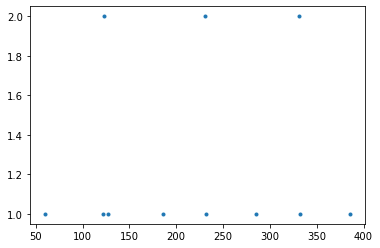

In [15]:
# extracting spikes data
dSD = sr.get("events")
evs = dSD["senders"]
ts = dSD["times"]
plt.plot(ts, evs, ".")

In [6]:
conns = nest.GetConnections(synapse_model="stdp_synapse")

In [7]:
conns.get("weight")

()

In [8]:
conns.get("target")

()

In [9]:
conns.get(["source", "target","weight"])

()